# Section 6.1: Generalized linear classifier

This page contains simulations in Section 6.1.

## Contents

    - FUNCTIONS
    - Histogram of $\beta_{-i}^T \tilde x_i$ versus the limiting Gaussian behavior
    - Comparison of expectation of $\beta$ to the optimal Bayes solution $\beta_*$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.optimize
import scipy.stats
pi = np.pi

## FUNCTIONS

In [2]:
def f(beta,X,gamma,loss_type):

    if loss_type == 'quadratic':
        L   = lambda t : (t-1)**2
        Lp  = lambda t : 2*(t-1)
    if loss_type == 'logistic':
        L   = lambda t : np.log(1+np.exp(-t))
        Lp  = lambda t : -1/(1+np.exp(t))
    if loss_type == 'exp':
        L   = lambda t : np.exp(-t)
        Lp  = lambda t : -np.exp(-t)
    if loss_type == 'hinge':
        L   = lambda t : np.maximum(0,1-t)
        Lp  = lambda t : t<=0

    n = np.shape(X)[1]
    loss = np.sum(L(beta.T@X))/n + gamma*np.linalg.norm(beta)**2/2
    grad = X@Lp(X.T@beta)/n + gamma*beta

    return loss,grad

def grad_descent(f, beta0, step, plot_loss):
    Tol = 1e-5  # tolerance
    MaxIter = 50000  # maximum number of iterations
    Dxmin = 1e-5  # minimum allowed perturbation

    gnorm  = np.inf 
    beta   = beta0
    nIter  = 0
    d_beta = np.inf

# gradient descent algorithm
    while (gnorm>=Tol and nIter <= MaxIter and d_beta >= Dxmin):
        loss,g = f(beta)
        gnorm  = np.linalg.norm(g)
        beta_new = beta - step*g
        
        # update termination metrics
        nIter += 1
        d_beta = np.linalg.norm(beta_new-beta)
        beta   = beta_new.copy()

        if plot_loss == 'yes':
            if np.mod(nIter,500)==0:
                print('Iteration {} | Cost: {}\r'.format(nIter, loss))

    beta_opt = beta
    f_opt = f(beta_opt)
            
    return beta_opt,f_opt

## Histogram of $\beta_{-i}^T \tilde x_i$ versus the limiting Gaussian behavior

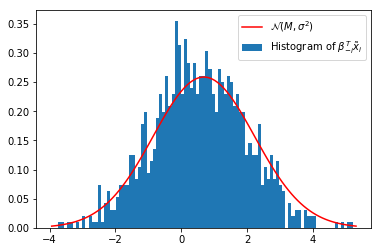

In [3]:
coeff = 1
p = 256*coeff
n = 1024*coeff

loss_type = 'logistic' # among 'quadratic', 'logistic' and 'exp'
gamma = 0.1            # regularization

if loss_type == 'quadratic':
    L   = lambda t : (t-1)**2
    Lp  = lambda t : 2*(t-1)
    Lpp = lambda t : 2
if loss_type == 'logistic':
    L   = lambda t : np.log(1+np.exp(-t))
    Lp  = lambda t : -1/(1+np.exp(t))
    Lpp = lambda t : np.exp(t)/((1+np.exp(t))**2)
if loss_type == 'exp':
    L   = lambda t : np.exp(-t)
    Lp  = lambda t : -np.exp(-t)
    Lpp = lambda t : np.exp(-t)

mu = np.ones(p)/np.sqrt(p)
C  = np.diag(np.concatenate([np.ones(p//4),3*np.ones(p//4),5*np.ones(p//2)]))
eigs_C = np.diag(C)

X = np.outer(mu,np.ones(n)) + scipy.linalg.sqrtm(C)@np.random.randn(p,n)
beta0 = np.random.randn(p)/np.sqrt(p) # random initialization of grandient descent to solve ERM
step = 1e-3
beta_opt = grad_descent( lambda beta : f(beta,X,gamma,loss_type), beta0, step, 'no')[0]

estim_delta = 1
tmp_delta = 0
while np.abs(estim_delta - tmp_delta) > 1e-6:
    tmp_delta = estim_delta
    tmp = np.mean(Lpp(beta_opt.T@X)/(1+estim_delta*Lpp(beta_opt.T@X)))
    estim_delta = np.sum( eigs_C/( tmp*eigs_C+gamma) )/n

r = beta_opt.T@X + estim_delta*Lp(beta_opt.T@X)
estim_M = np.mean(r)
estim_sigma2 = np.var(r) # Using empirical estimation as initialization of fixed-point equations


param = np.array([estim_M,np.sqrt(estim_sigma2),estim_delta]) #param[0]=M, param[1]=sqrt(sigma2), param[2]=delta
param_tmp = np.zeros(3)

nb_average = 1000
z = np.random.randn(nb_average)

while np.min(np.abs(param - param_tmp)) > 1e-6:
    param_tmp = param.copy()

    M = param[0]
    sigma = param[1]
    delta = param[2]

    r = M+sigma*z
    prox_r0 = np.random.randn(len(r))

    find_prox_r = lambda x : delta*Lp(x)+x-r
    prox_r = scipy.optimize.fsolve(find_prox_r, prox_r0) # numerically find the prox
    f_r = -Lp(prox_r)
    #f_r = (prox_r-r)/delta

    tmp_delta = 0  # fixed-point iteration to determine delta
    while np.abs(delta - tmp_delta) > 1e-5:
        tmp_delta = delta
        tmp = np.mean(Lpp(prox_r)/(1+delta*Lpp(prox_r)))
        delta = np.sum( eigs_C/( tmp*eigs_C+gamma) )/n

    E_f_p = -np.mean(f_r*z)/sigma
    E_f   =  np.mean(f_r)
    E_f2  =  np.mean(f_r**2)

    inv_shortcut = np.linalg.solve(E_f_p*C+gamma*np.eye(p),mu)
    M = E_f*mu.T@inv_shortcut
    sigma2 = E_f**2*inv_shortcut.T@C@inv_shortcut + E_f2*np.linalg.norm(np.linalg.solve(E_f_p*C+gamma*np.eye(p),C),ord='fro')**2/n

    param = np.array([M,np.sqrt(sigma2),delta])

# compare to leave-one-out empirical results
store_r = np.zeros(n)
for i in range(n):
    xi  = X[:,i]
    X_i = np.concatenate([X[:,:i],X[:,i+1:]],axis=1)

    beta0  = np.random.randn(p)/np.sqrt(p)
    step   = 1e-3
    beta_i = grad_descent( lambda beta : f(beta,X_i,gamma,loss_type),beta0, step, 'no')[0]

    store_r[i] = beta_i.T@xi

xs = np.linspace(M-3*sigma,M+3*sigma,100)

plt.hist(store_r,bins=xs,weights=1/(xs[1]-xs[0])/n*np.ones(n),label=r'Histogram of $\beta_{-i}^T \tilde{x}_i$')
plt.plot(xs,[scipy.stats.norm.pdf(x,loc=M,scale=sigma) for x in xs],'r',label=r'$\mathcal{N}(M,\sigma^2)$')
_ = plt.legend()

## Comparison of expectation of $\beta$ to the optimal Bayes solution $\beta_*$

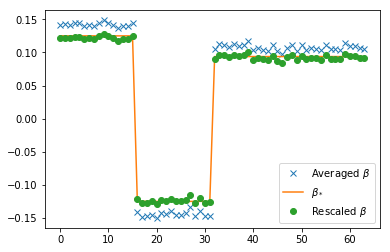

In [4]:
coeff = 1
p = 64*coeff
n = 512*coeff

loss_type = 'logistic' # among 'quadratic', 'logistic' and 'exp'
gamma = 0              # unregularized case!

if loss_type == 'quadratic':
    L   = lambda t : (t-1)**2
    Lp  = lambda t : 2*(t-1)
    Lpp = lambda t : 2
if loss_type == 'logistic':
    L   = lambda t : np.log(1+np.exp(-t))
    Lp  = lambda t : -1/(1+np.exp(t))
    Lpp = lambda t : np.exp(t)/((1+np.exp(t))**2)
if loss_type == 'exp':
    L   = lambda t : np.exp(-t)
    Lp  = lambda t : -np.exp(-t)
    Lpp = lambda t : np.exp(-t)

mu = np.concatenate([np.ones(p//4),-np.ones(p//4),3/4*np.ones(p//2)])/np.sqrt(p)
C  = 2*np.eye(p)
eigs_C = np.diag(C)
    
beta_store = np.zeros(p)
rescale_beta_store = np.zeros(p)

nb_average=500
for i in range(nb_average):
    X = np.outer(mu,np.ones(n)) + scipy.linalg.sqrtm(C)@np.random.randn(p,n)
    
    beta0 = np.random.randn(p)/np.sqrt(p) # random initialization of grandient descent to solve ERM
    
    step = 1e-3
    beta_opt = grad_descent( lambda beta : f(beta,X,gamma,loss_type), beta0, step, 'no')[0]

    estim_delta = 1
    tmp_delta = 0
    while np.abs(estim_delta - tmp_delta) > 1e-6:
        tmp_delta = estim_delta
        tmp = np.mean(Lpp(beta_opt.T@X)/(1+estim_delta*Lpp(beta_opt.T@X)))
        estim_delta = np.sum( eigs_C/( tmp*eigs_C+gamma) )/n

    r = beta_opt.T@X + estim_delta*Lp(beta_opt.T@X)
    estim_E_f = np.mean(-Lp(beta_opt.T@X))
    estim_E_f_p = np.mean(Lp(beta_opt.T@X)*(r-np.mean(r))/np.var(r))
    
    beta_store += beta_opt/nb_average
    rescale_beta_store += 2*estim_E_f_p/estim_E_f*beta_opt/nb_average

plt.plot(beta_store,'x',label=r'Averaged $\beta$')
beta_star = np.linalg.solve(C,mu)*2
plt.plot(beta_star,label=r'$\beta_*$')
plt.plot(rescale_beta_store,'o',label=r'Rescaled $\beta$')
_ = plt.legend()
